# Reddit Post Labels — Bar Plot

This notebook:
1. Pulls reddit posts from InfluxDB (measurement: `reddit_post`)
2. Counts the 3 sentiment labels written to `stance_label`
3. Plots a bar chart of label counts

> If your measurement/field names differ (e.g. comments vs posts), adjust the Flux query cell.


In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# If influx_io.py is in the same folder as this notebook, this usually works:
sys.path.insert(0, os.getcwd())

# If it's somewhere else, add that folder too (edit if needed):
# sys.path.insert(0, "/path/to/your/project")

from influx_io import get_client, INFLUX_BUCKET, INFLUX_ORG


In [2]:
def load_reddit_posts_with_labels(lookback: str = "30d", limit: int = 10000) -> pd.DataFrame:
    """
    Loads reddit posts that already have a stance_label.
    Returns a DataFrame with at least: _time, usid, source, title, selftext, stance_label
    """
    with get_client() as client:
        query_api = client.query_api()
        flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{lookback})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","usid","source","title","selftext","stance_label"])
  |> filter(fn: (r) => exists r.stance_label and r.stance_label != "")
  |> limit(n: {int(limit)})
"""
        tables = query_api.query(flux, org=INFLUX_ORG)

    rows = []
    for t in tables:
        for rec in t.records:
            v = rec.values
            rows.append({
                "_time": v.get("_time"),
                "usid": v.get("usid"),
                "source": v.get("source"),
                "title": v.get("title") or "",
                "selftext": v.get("selftext") or "",
                "stance_label": v.get("stance_label") or "",
            })

    return pd.DataFrame(rows)

df = load_reddit_posts_with_labels(lookback="30d", limit=10000)
df.head(), len(df)


(                      _time          usid      source  \
 0 2026-01-06 12:53:14+00:00  news:3417172  AlgosOneAI   
 1 2025-12-29 06:26:25+00:00  news:3417135     Austria   
 2 2025-12-24 23:40:10+00:00  news:3417166     Austria   
 3 2025-12-21 21:18:23+00:00  news:3417168     Austria   
 4 2025-12-22 14:28:54+00:00  news:3417168     Austria   
 
                                                title  \
 0                             Punkt 7.6 AGB Algosone   
 1  Neue Familien-Statistik veröffentlicht: Geburt...   
 2  2025 hat mir gezeigt wieso öffentlich-rechtlic...   
 3  Kind warf Minifeuerwerkskörper von Lift und lö...   
 4         Tödlicher Unfall auf Radweg: Bedingte Haft   
 
                                             selftext stance_label  
 0  Hallo zusammen ich wurde von AlgosOne auf die ...      neutral  
 1  Hier ein paar grobe Fakten aus dem ORF und TT ...      neutral  
 2  Es ist ja kein Geheimnis dass viele von uns mi...      neutral  
 3  Im Skigebiet Spieljoch (Zi

In [3]:
# Count the 3 labels
counts = df["stance_label"].value_counts().sort_index()
counts


stance_label
negative    27
neutral     35
positive     3
Name: count, dtype: int64

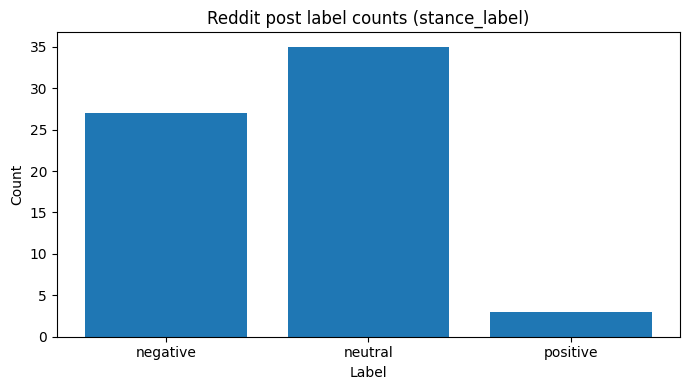

In [4]:
# Bar plot (no explicit colors per best practice)
plt.figure(figsize=(7,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Reddit post label counts (stance_label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


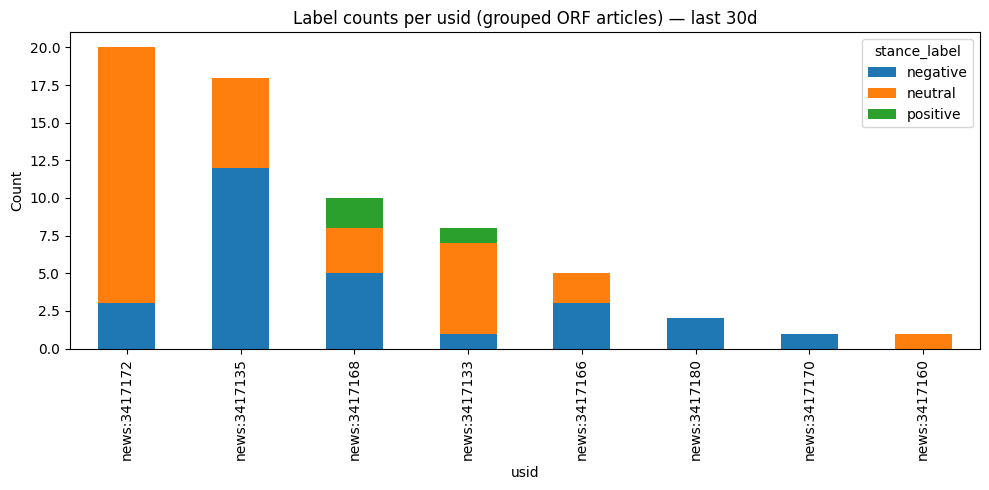

stance_label,negative,neutral,positive
usid,,,
news:3417172,3,17,0
news:3417135,12,6,0
news:3417168,5,3,2
news:3417133,1,6,1
news:3417166,3,2,0
news:3417180,2,0,0
news:3417170,1,0,0
news:3417160,0,1,0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

LOOKBACK = "30d"   # adjust (e.g. "180d")
LIMIT = 100000     # adjust if needed
TOP_N = 10        # show top N usids (most rows). set None to show all (can get messy)

# --- Load labeled reddit posts from Influx ---
with get_client() as client:
    q = client.query_api()
    flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{LOOKBACK})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","usid","stance_label"])
  |> filter(fn: (r) => exists r.stance_label and r.stance_label != "")
  |> limit(n: {int(LIMIT)})
"""
    tables = q.query(flux, org=INFLUX_ORG)

rows = []
for t in tables:
    for rec in t.records:
        v = rec.values
        rows.append({
            "_time": v.get("_time"),
            "usid": v.get("usid"),
            "stance_label": v.get("stance_label") or "",
        })

df = pd.DataFrame(rows)

if df.empty:
    print("No labeled reddit_post rows found.")
else:
    df["stance_label"] = df["stance_label"].astype(str).str.lower()

    # Count labels per usid
    counts = (
        df.groupby(["usid", "stance_label"])
          .size()
          .unstack(fill_value=0)
    )

    # Ensure the 3 expected columns exist (and order them)
    for col in ["negative", "neutral", "positive"]:
        if col not in counts.columns:
            counts[col] = 0
    counts = counts[["negative", "neutral", "positive"]]

    # Choose which usids to plot
    if TOP_N:
        counts = counts.sort_values(by=["negative","neutral","positive"], ascending=False)
        # better: sort by total rows
        counts["total"] = counts.sum(axis=1)
        counts = counts.sort_values("total", ascending=False).drop(columns=["total"]).head(TOP_N)

    # Plot stacked bars (one bar per usid)
    ax = counts.plot(kind="bar", stacked=True, figsize=(max(10, len(counts)*1.2), 5))
    ax.set_title(f"Label counts per usid (grouped ORF articles) — last {LOOKBACK}")
    ax.set_xlabel("usid")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Optional: display the underlying table
    display(counts)


Scoring method: tfidf
Joined pairs: 102
ORF covered (any match): 9 / 11


,threshold,coverage,avg_score,matches
0,0.10,0.555556,0.382033,9
1,0.15,0.444444,0.587959,5
2,0.20,0.444444,0.694238,4
3,0.25,0.333333,0.856886,3
4,0.30,0.333333,0.856886,3
5,0.35,0.333333,0.856886,3
6,0.40,0.333333,0.856886,3
7,0.45,0.333333,0.856886,3
8,0.50,0.333333,0.856886,3
9,0.55,0.333333,0.856886,3


,usid,orf_title,sim_title_full,margin_top1_top2
24,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,0.023368,0.000627
17,news:3417168,Von der Leyen wieder mit Misstrauensvotum konf...,0.061646,0.001743
31,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,0.060802,0.025693
29,news:3417179,Notstandsmaßnahmen gegen verzweifelte Lage in ...,0.079492,0.037175
0,news:3417133,Japan – Südkorea: Spitzenpolitiker mit Jamsession,0.116755,0.055824
12,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer ...,0.206292,0.064526
5,news:3417135,Weiter Differenzen mit USA wegen Grönland,0.661849,0.499005
22,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,0.908810,0.890939
10,news:3417160,USA setzen Visavergabe für 75 Länder aus,1.000000,0.935881


,usid,orf_title,reddit_id,reddit_title,sim_title_full,sim_title_title,margin_top1_top2,source
10,news:3417160,USA setzen Visavergabe für 75 Länder aus,1qcugno,USA setzen Visavergabe für 75 Länder aus,1.000000,1.000000,0.935881,USA_de
22,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,1qcuh5k,Technokratenregierung: USA läuten Phase zwei v...,0.908810,0.908810,0.890939,USA_de
5,news:3417135,Weiter Differenzen mit USA wegen Grönland,1qcyn8p,Dänemark nach Treffen: Weiter Differenzen mit ...,0.661849,0.661849,0.499005,USA_de
12,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer ...,1qcuh5k,Technokratenregierung: USA läuten Phase zwei v...,0.206292,0.206292,0.064526,USA_de
6,news:3417135,Weiter Differenzen mit USA wegen Grönland,1q5f49t,Trump-Berater: Niemand wird mit USA um Grönlan...,0.162843,0.162843,0.499005,USA_de
13,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer ...,1prgnij,"Was macht Trumps Gaza Friedensplan eigentlich,...",0.141766,0.194163,0.064526,Staiy
7,news:3417135,Weiter Differenzen mit USA wegen Grönland,1qd5ln4,Wie geht es mit Grönland weiter,0.123694,0.154574,0.499005,KeineDummenFragen
0,news:3417133,Japan – Südkorea: Spitzenpolitiker mit Jamsession,1ppo0bh,Japan oder zum 1. Mal Korea,0.116755,0.063947,0.055824,reisende
8,news:3417135,Weiter Differenzen mit USA wegen Grönland,1q83ejj,Insider: USA bereits in Gesprächen mit Grönland,0.116285,0.116285,0.499005,USA_de
29,news:3417179,Notstandsmaßnahmen gegen verzweifelte Lage in ...,1ouaqfm,Dauernachtdienst - Verzweifelte Lage,0.079492,0.369258,0.037175,Pflege


,usid,orf_title,reddit_id,reddit_title,sim_title_full,sim_title_title,margin_top1_top2,source
35,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1q8382w,Unmut über Wiener Gastpatienten-Regelung,0.016184,0.026276,0.025693,Austria
28,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1q82bs8,True Crime Wirtschaftskrimi / Deutschland 2026...,0.017022,0.000000,0.000627,u_JamesTillyMatthews
23,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,1pkbaso,Nationalrat beschloss Mietpreisbremse,0.017871,0.000000,0.890939,wien
27,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1q5zghs,"Warum häng ich nach 1,5 Jahren immer noch an m...",0.019713,0.000000,0.000627,FragtMaenner
26,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1pxmhi4,RFID Chip Kleidung für Hotels & Gastronomie,0.021155,0.000000,0.000627,bekleidungsautomat
9,news:3417135,Weiter Differenzen mit USA wegen Grönland,1q5dvrz,Krankenhaus möchte mich unbedingt entlassen,0.021978,0.000000,0.499005,Ratschlag
25,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1qcalf4,Story,0.022740,0.000000,0.000627,GeminiAI
34,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1oofab4,"Wieso macht Österreich nichts gegen Temu, Shei...",0.023213,0.011658,0.025693,Austria
24,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,1q97ouh,SPAD + Biophotonen = die nächste Stufe der Pho...,0.023368,0.000000,0.000627,u_Loud_Noise1959
33,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1pfm55w,Weihnachtskekse-Schwarzmarkt,0.031769,0.000000,0.025693,Austria


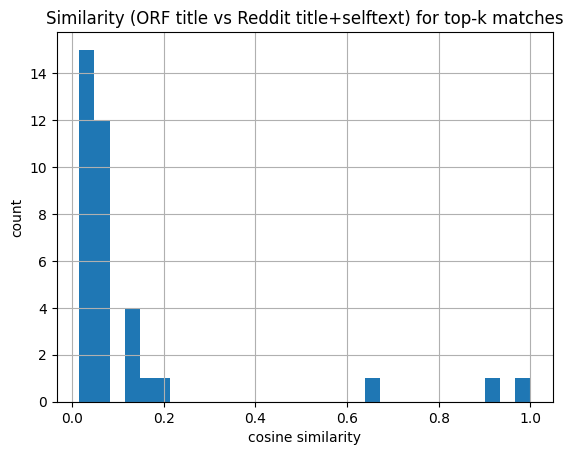

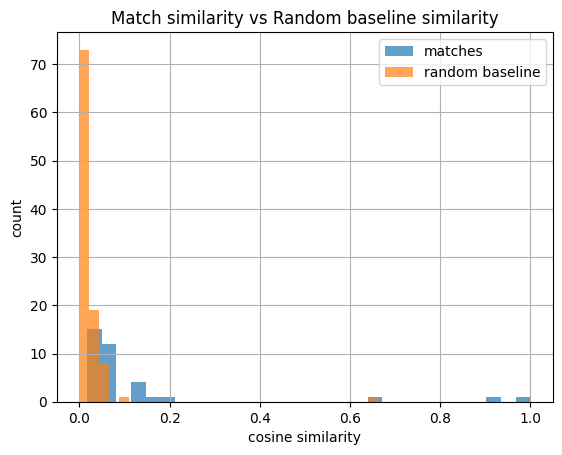

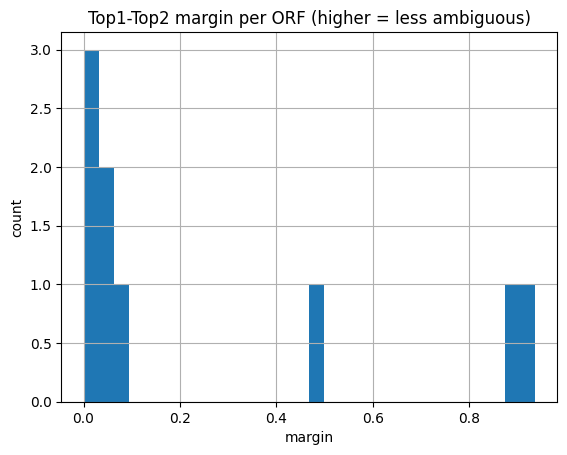

In [6]:
"""
Evaluate how well reddit posts "fit" ORF titles (only ORF title available).

What it does:
1) Pull ORF titles from Influx (measurement: orf_article).
2) Pull Reddit posts from Influx (measurement: reddit_post).
3) Join via usid (since your reddit_post has tag usid = article_usid).
4) Compute similarity metrics between ORF title and reddit text.
5) Produce quality diagnostics:
   - Precision proxy via thresholding (coverage vs threshold)
   - Random-baseline separation
   - Top-1 margin per ORF (ambiguity)
   - Tables: best/worst matches and most ambiguous ORF posts

Requires:
- pandas
- scikit-learn

Optional (recommended if you have it):
- sentence-transformers (embeddings). If not installed, it falls back to TF-IDF.
"""

import os
import numpy as np
import pandas as pd

from datetime import datetime, timezone
from influxdb_client import InfluxDBClient

# -------------------------
# Influx config (env vars)
# -------------------------
INFLUX_URL = os.getenv("INFLUX_URL", "http://localhost:8086")
INFLUX_TOKEN = os.getenv("INFLUX_TOKEN", "bigdata-dev-token")
INFLUX_ORG = os.getenv("INFLUX_ORG", "bigdata")
INFLUX_BUCKET = os.getenv("INFLUX_BUCKET", "bigdata_bucket")


def get_client() -> InfluxDBClient:
    return InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)


# -------------------------
# Load ORF titles (only)
# -------------------------
def load_orf_titles_df(lookback: str = "30d", limit: int = 5000) -> pd.DataFrame:
    """
    Loads ORF posts (measurement 'orf_article').
    Returns df: usid, orf_time, orf_title, category, link
    """
    flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{lookback})
  |> filter(fn: (r) => r._measurement == "orf_article")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","usid","title","category","link"])
  |> sort(columns: ["_time"], desc: true)
  |> limit(n: {int(limit)})
"""
    with get_client() as client:
        df = client.query_api().query_data_frame(flux, org=INFLUX_ORG)

    if isinstance(df, list):
        df = pd.concat(df, ignore_index=True) if df else pd.DataFrame()

    if df.empty:
        return df

    df = df.rename(columns={"_time": "orf_time", "title": "orf_title"})
    df["usid"] = df["usid"].astype(str).str.strip()
    df["orf_title"] = df["orf_title"].fillna("").astype(str)
    return df[["usid", "orf_time", "orf_title", "category", "link"]].drop_duplicates(subset=["usid"])


# -------------------------
# Load Reddit posts
# -------------------------
def load_reddit_posts_df(lookback: str = "30d", limit: int = 20000) -> pd.DataFrame:
    """
    Loads reddit posts (measurement 'reddit_post').
    Returns df: usid, reddit_time, reddit_id, reddit_title, selftext, source, stance_label, stance_conf
    """
    flux = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -{lookback})
  |> filter(fn: (r) => r._measurement == "reddit_post")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["_time","usid","source","reddit_id","title","selftext","stance_label","stance_conf"])
  |> sort(columns: ["_time"], desc: true)
  |> limit(n: {int(limit)})
"""
    with get_client() as client:
        df = client.query_api().query_data_frame(flux, org=INFLUX_ORG)

    if isinstance(df, list):
        df = pd.concat(df, ignore_index=True) if df else pd.DataFrame()

    if df.empty:
        return df

    df = df.rename(columns={"_time": "reddit_time", "title": "reddit_title"})
    df["usid"] = df["usid"].astype(str).str.strip()
    df["reddit_id"] = df["reddit_id"].fillna("").astype(str)
    df["reddit_title"] = df["reddit_title"].fillna("").astype(str)
    df["selftext"] = df["selftext"].fillna("").astype(str)
    df["source"] = df["source"].fillna("").astype(str)
    df["stance_label"] = df.get("stance_label", "").fillna("").astype(str)
    df["stance_conf"] = pd.to_numeric(df.get("stance_conf", 0.0), errors="coerce").fillna(0.0)

    # drop rows without reddit_id (shouldn't happen, but avoids weird joins)
    df = df[df["reddit_id"].str.len() > 0].copy()
    return df


# -------------------------
# Similarity computation
# -------------------------
def _try_sentence_transformers():
    try:
        from sentence_transformers import SentenceTransformer
        return SentenceTransformer
    except Exception:
        return None


def compute_similarity(joined: pd.DataFrame, use_embeddings: bool = True) -> pd.DataFrame:
    """
    Adds columns:
      - sim_title_title: ORF title vs reddit title
      - sim_title_full:  ORF title vs (reddit title + selftext)
    """
    if joined.empty:
        return joined

    orf = joined["orf_title"].fillna("").astype(str).tolist()
    rt = joined["reddit_title"].fillna("").astype(str).tolist()
    rf = (joined["reddit_title"].fillna("").astype(str) + "\n" + joined["selftext"].fillna("").astype(str)).tolist()

    SentenceTransformer = _try_sentence_transformers()

    if use_embeddings and SentenceTransformer is not None:
        # --- Embeddings path ---
        from numpy.linalg import norm

        model = SentenceTransformer("all-MiniLM-L6-v2")  # small + fast + decent
        e_orf = model.encode(orf, normalize_embeddings=True)
        e_rt = model.encode(rt, normalize_embeddings=True)
        e_rf = model.encode(rf, normalize_embeddings=True)

        sim_tt = (e_orf * e_rt).sum(axis=1)
        sim_tf = (e_orf * e_rf).sum(axis=1)

        out = joined.copy()
        out["sim_title_title"] = sim_tt.astype(float)
        out["sim_title_full"] = sim_tf.astype(float)
        out["sim_method"] = "embeddings"
        return out

    # --- TF-IDF fallback ---
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    # Fit on combined corpus to share vocabulary
    corpus = orf + rt + rf
    vec = TfidfVectorizer(
        lowercase=True,
        stop_words=None,      # keep None unless you want German stopwords
        ngram_range=(1, 2),
        min_df=2
    )
    X = vec.fit_transform(corpus)

    X_orf = X[0:len(orf)]
    X_rt  = X[len(orf):len(orf)+len(rt)]
    X_rf  = X[len(orf)+len(rt):]

    sim_tt = cosine_similarity(X_orf, X_rt).diagonal()
    sim_tf = cosine_similarity(X_orf, X_rf).diagonal()

    out = joined.copy()
    out["sim_title_title"] = sim_tt.astype(float)
    out["sim_title_full"] = sim_tf.astype(float)
    out["sim_method"] = "tfidf"
    return out


# -------------------------
# Evaluation diagnostics (proxy accuracy)
# -------------------------
def add_orf_rank_and_margin(scored: pd.DataFrame, score_col: str = "sim_title_full") -> pd.DataFrame:
    """
    For each ORF usid:
      - rank reddit matches by score
      - compute margin = top1 - top2
    """
    if scored.empty:
        return scored

    scored = scored.copy()
    scored["rank"] = scored.groupby("usid")[score_col].rank(ascending=False, method="first").astype(int)

    # margin per ORF: top1 - top2
    top = scored[scored["rank"].isin([1, 2])].copy()
    piv = top.pivot_table(index="usid", columns="rank", values=score_col, aggfunc="max")
    # columns: 1,2 maybe missing
    piv["margin_top1_top2"] = (piv.get(1, np.nan) - piv.get(2, np.nan)).astype(float)
    piv = piv[["margin_top1_top2"]].reset_index()

    scored = scored.merge(piv, on="usid", how="left")
    return scored


def random_baseline(scored: pd.DataFrame, n: int = 5000, score_col: str = "sim_title_full", use_embeddings: bool = True) -> pd.DataFrame:
    """
    Builds a random pairing baseline:
      - keeps ORF titles but assigns random reddit texts
      - recomputes similarity for the sample
    Returns df with baseline similarity column `baseline_score`.
    """
    if scored.empty:
        return pd.DataFrame()

    base = scored[["usid", "orf_title", "reddit_title", "selftext"]].copy()
    base = base.sample(n=min(n, len(base)), random_state=42).reset_index(drop=True)

    # shuffle reddit texts
    shuffled = base[["reddit_title", "selftext"]].sample(frac=1.0, random_state=42).reset_index(drop=True)
    base["reddit_title"] = shuffled["reddit_title"]
    base["selftext"] = shuffled["selftext"]

    baseline_scored = compute_similarity(
        base.assign(reddit_id="__baseline__", reddit_time=pd.Timestamp.now(tz="UTC"), source="baseline", stance_label="", stance_conf=0.0),
        use_embeddings=use_embeddings
    )
    baseline_scored = baseline_scored.rename(columns={score_col: "baseline_score"})
    return baseline_scored[["baseline_score", "sim_method"]]


def coverage_vs_threshold(scored: pd.DataFrame, thresholds=None, score_col: str = "sim_title_full") -> pd.DataFrame:
    """
    For each threshold, compute:
      - coverage: % ORF usids with >=1 reddit match above threshold
      - avg_score: mean score among kept matches
      - matches: number of kept matches
    """
    if thresholds is None:
        thresholds = np.round(np.linspace(0.10, 0.70, 13), 2)

    if scored.empty:
        return pd.DataFrame(columns=["threshold", "coverage", "avg_score", "matches"])

    usids_total = scored["usid"].nunique()
    rows = []
    for thr in thresholds:
        kept = scored[scored[score_col] >= thr]
        cov = (kept["usid"].nunique() / usids_total) if usids_total else 0.0
        avg = float(kept[score_col].mean()) if len(kept) else np.nan
        rows.append({"threshold": float(thr), "coverage": float(cov), "avg_score": avg, "matches": int(len(kept))})
    return pd.DataFrame(rows)


# -------------------------
# Main runner
# -------------------------
def evaluate_orf_reddit_fit(
    lookback_orf: str = "30d",
    lookback_reddit: str = "30d",
    orf_limit: int = 5000,
    reddit_limit: int = 20000,
    use_embeddings: bool = True,
    score_col: str = "sim_title_full",
    topk: int = 5,
):
    # 1) load
    orf_df = load_orf_titles_df(lookback=lookback_orf, limit=orf_limit)
    reddit_df = load_reddit_posts_df(lookback=lookback_reddit, limit=reddit_limit)

    if orf_df.empty:
        raise RuntimeError("No ORF articles found. Check measurement name 'orf_article' and lookback window.")
    if reddit_df.empty:
        raise RuntimeError("No Reddit posts found. Check measurement name 'reddit_post' and lookback window.")

    # 2) join via usid
    joined = reddit_df.merge(orf_df[["usid", "orf_title"]], on="usid", how="inner")

    if joined.empty:
        raise RuntimeError("No join results. Are reddit_post.usid and orf_article.usid matching?")

    # 3) score similarity
    scored = compute_similarity(joined, use_embeddings=use_embeddings)
    scored = add_orf_rank_and_margin(scored, score_col=score_col)

    # 4) pick top-k per ORF (what you likely store / inspect)
    top_matches = scored[scored["rank"] <= topk].sort_values(["usid", "rank"]).reset_index(drop=True)

    # 5) diagnostics
    cov_df = coverage_vs_threshold(scored, score_col=score_col)
    baseline_df = random_baseline(scored, n=5000, score_col=score_col, use_embeddings=use_embeddings)

    # 6) handy tables
    best = top_matches.sort_values(score_col, ascending=False).head(20)[
        ["usid", "orf_title", "reddit_id", "reddit_title", score_col, "sim_title_title", "margin_top1_top2", "source"]
    ]

    worst = top_matches.sort_values(score_col, ascending=True).head(20)[
        ["usid", "orf_title", "reddit_id", "reddit_title", score_col, "sim_title_title", "margin_top1_top2", "source"]
    ]

    ambiguous_orf = (
        top_matches[top_matches["rank"] == 1]
        .sort_values("margin_top1_top2", ascending=True)
        .head(30)[["usid", "orf_title", score_col, "margin_top1_top2"]]
    )

    return {
        "orf_df": orf_df,
        "reddit_df": reddit_df,
        "joined_scored": scored,
        "top_matches": top_matches,
        "coverage_vs_threshold": cov_df,
        "random_baseline_scores": baseline_df,
        "best_examples": best,
        "worst_examples": worst,
        "most_ambiguous_orf": ambiguous_orf,
    }


# -------------------------
# Example usage (in your notebook)
# -------------------------
results = evaluate_orf_reddit_fit(
    lookback_orf="90d",
    lookback_reddit="90d",
    orf_limit=5000,
    reddit_limit=50000,
    use_embeddings=True,   # set False if you don't have sentence-transformers
    score_col="sim_title_full",
    topk=5,
)

print("Scoring method:", results["joined_scored"]["sim_method"].iloc[0])
print("Joined pairs:", len(results["joined_scored"]))
print("ORF covered (any match):", results["joined_scored"]["usid"].nunique(), "/", results["orf_df"]["usid"].nunique())

display(results["coverage_vs_threshold"].head(10))
display(results["most_ambiguous_orf"])
display(results["best_examples"])
display(results["worst_examples"])

# Optional quick plots (matplotlib only)
import matplotlib.pyplot as plt

# Histogram of match scores
plt.figure()
results["top_matches"]["sim_title_full"].hist(bins=30)
plt.title("Similarity (ORF title vs Reddit title+selftext) for top-k matches")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.show()

# Baseline vs match histogram (if baseline exists)
if not results["random_baseline_scores"].empty:
    plt.figure()
    results["top_matches"]["sim_title_full"].sample(n=min(5000, len(results["top_matches"])), random_state=42).hist(bins=30, alpha=0.7)
    results["random_baseline_scores"]["baseline_score"].hist(bins=30, alpha=0.7)
    plt.title("Match similarity vs Random baseline similarity")
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.legend(["matches", "random baseline"])
    plt.show()

# Margin distribution (ambiguity)
plt.figure()
m = results["top_matches"][results["top_matches"]["rank"] == 1]["margin_top1_top2"].dropna()
m.hist(bins=30)
plt.title("Top1-Top2 margin per ORF (higher = less ambiguous)")
plt.xlabel("margin")
plt.ylabel("count")
plt.show()
